In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
import ROOT as r
import time
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

Welcome to JupyROOT 6.26/00


In [2]:
def fit(nsamples,nbins):
    cols=[f'toybin{i:02d}' for i in range(nbins)]
    diagnostics_df=pd.DataFrame(columns=cols,index=['sigma_median','mcse','rhat'])
    sigma_df=pd.DataFrame(columns=cols)
    for i in range(nbins):#no. of toy bins
        #read data
        df=pd.read_csv(f"toybins/toybin{i:02d}.txt",sep="\t")
        #df=pd.read_csv(f"new_toy_MC.txt",sep="\t")
        df.columns=['pol','phi','weight']
        #these are prompt peak events
        prmpt=df.loc[df['weight']==1]
        prmpt=prmpt.reset_index(drop=True)
        #sideband
        side=df.loc[df['weight']!=1]
        side=side.reset_index(drop=True)
        nprmpt=len(prmpt)
        total_nside=(len(side))
        #weights used in the data, including 1--> exterminate 1
        weights=pd.unique(df['weight'].values)
        weights=np.array(weights[weights!=1])
        #sideband events are identified by the corresponding weights
        nside=np.array([len(df.loc[df['weight']==weights[i]])for i in range(len(weights))])
        #fraction of signal in prompt peak, note that the weights are already negative (TO BE CHECKED W/ FARAHS DATA!)
        f=(nprmpt+np.sum(nside*weights))/nprmpt
        print(f)
        stan_data={
            'N':nprmpt, #no. of prompt peak events and corresponding pol and phi values
            'phi_prmpt':list(prmpt['phi'].values),
            'pol_prmpt':list(prmpt['pol'].values),
            'M':total_nside,#no. of sideband events and..
            'phi_side':list(side['phi'].values),
            'pol_side':list(side['pol'].values),
            'f':f #fraction of signal in prmpt peak
        }
        print(nprmpt, total_nside)
        #now the stan model and mcmc
        model=sp.CmdStanModel(stan_file='toyMC_stan.stan')
        model.compile()
        fitobj=model.sample(data=stan_data,iter_sampling=nsamples,inits=0)
        summary=fitobj.summary()
        samples=fitobj.draws_pd()
        #get mcmc diagnostics
        median=summary['50%']['sigma']
        mcse=(az.mcse(np.transpose(fitobj.draws(concat_chains=False)[:,:,7]),method='median'))
        rhat=(summary['R_hat']['sigma'])
        tmp_list=[median,mcse,rhat]
        currbin=f"toybin{i:02d}"
        diagnostics_df[currbin]=tmp_list
        sigma_df[currbin]=samples['sigma']
    return diagnostics_df, sigma_df, summary

In [3]:
dfs=fit(nsamples=1000,nbins=10)
diagnostics=dfs[0]
sigma=dfs[1]
diagnostics.to_csv('toy_diagnostics.csv')
sigma.to_csv('toy_sigma.csv')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


0.9497152507198229
1806 2373


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



0.9494358544463569
1743 2303


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



0.9495985219047619
1785 2352


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



0.9497152507198229
1806 2373


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



0.9497199841078601
1743 2291


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



0.9499390351735914
1757 2299


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



0.949933081296615
1743 2281


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



0.9498706306442577
1785 2339


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



0.9498461446712018
1764 2313


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing



0.9498299477324263
1764 2313


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [2]:
sigma_df=pd.read_csv('toy_sigma.csv',index_col=0)
diagnostics_df=pd.read_csv('toy_diagnostics.csv',index_col=0)

In [3]:
diagnostics_df

,toybin00,toybin01,toybin02,toybin03,toybin04,toybin05,toybin06,toybin07,toybin08,toybin09,...,toybin90,toybin91,toybin92,toybin93,toybin94,toybin95,toybin96,toybin97,toybin98,toybin99
sigma_median,0.630000,0.600000,0.570000,0.340000,0.470000,0.640000,0.490000,0.550000,0.470000,0.300000,...,0.600000,0.390000,0.490000,0.620000,0.340000,0.520000,0.680000,0.590000,0.39000,0.740000
mcse,0.002066,0.002075,0.001668,0.001962,0.002053,0.002133,0.002194,0.001785,0.001577,0.002223,...,0.001653,0.002146,0.001576,0.002041,0.002155,0.001886,0.002372,0.002163,0.00205,0.001762
rhat,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


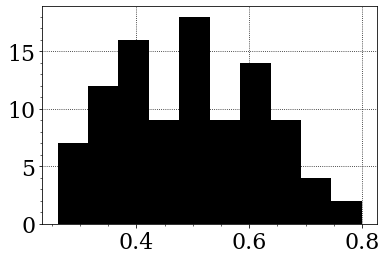

In [4]:

medians=[(diagnostics_df[f'toybin{i:02d}']['sigma_median']) for i in range(100)]
plt.hist(medians)
plt.show()

In [21]:
all_sigmas=[]
for i in range(100):
    all_sigmas.extend((np.array(sigma_df[f'toybin{i:02d}'].values)-0.5)/np.std(sigma_df[f'toybin{i:02d}'].values,ddof=1))

In [22]:
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
mu=np.mean(all_sigmas)
sigma=np.std(all_sigmas)

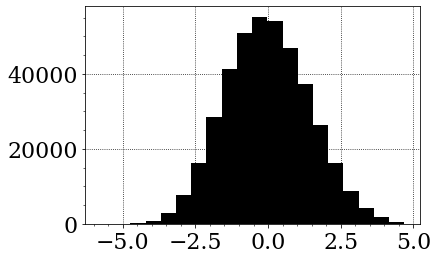

In [23]:
plt.hist(all_sigmas,bins=20)
plt.show()

In [24]:
h=r.TH1D("h","h",100,-5,5)
for i in range(len(all_sigmas)):
    h.Fill(all_sigmas[i])
    

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


In [27]:
c=r.TCanvas()
c.Draw("")
h.Draw("")
h.Fit("gaus")

 FCN=2821.59 FROM MIGRAD    STATUS=CONVERGED      53 CALLS          54 TOTAL
                     EDM=2.56948e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.11026e+04   2.09624e+01   4.57020e-01   3.33851e-07
   2  Mean        -1.64949e-02   2.33054e-03   5.90452e-05  -1.18306e-02
   3  Sigma        1.42809e+00   1.47434e-03   7.33834e-06   2.21703e-01
/usr/include/c++/11.2.0/bits/shared_ptr_base.h:979: std::__shared_ptr_access<_Tp, _Lp, <anonymous>, <anonymous> >::element_type& std::__shared_ptr_access<_Tp, _Lp, <anonymous>, <anonymous> >::operator*() const [with _Tp = TFitResult; __gnu_cxx::_Lock_policy _Lp = __gnu_cxx::_S_atomic; bool <anonymous> = false; bool <anonymous> = false; std::__shared_ptr_access<_Tp, _Lp, <anonymous>, <anonymous> >::element_type = TFitResult]: Assertion '_M_get() != nullptr' failed.
/usr/includ

Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
 *** Break *** abort
 Generating stack trace...
 0x00007fd333aa04b8 in raise at :? from /usr/lib/libc.so.6
 0x00007fd333a8a534 in abort at :? from /usr/lib/libc.so.6
 0x00007fd2c73260be in TFitResultPtr::operator*() const + 0x5e from /usr/lib/root/libHist.so
 0x00007fd2cc67a024 in <unknown function>
 0x00007fd2df0b7f47 in <unknown> from /usr/lib/root/libcppyy_backend3_10.so
 0x00007fd2df0b9534 in Cppyy::CallR(long, void*, unsigned long, void*) + 0x34 from /usr/lib/root/libcppyy_backend3_10.so
 0x00007fd2df17b9e4 in <unknown> from /usr/lib/python3.10/site-packages/libcppyy3_10.so
 0x00007fd2df1612a6 in <unknown> from /usr/lib/python3.10/site-packages/libcppyy3_10.so
 0x00007fd2df163dc0 in CPyCppyy::CPPMethod::ExecuteProtected(void*, long, CPyCppyy::CallContext*) + 0x120 from /usr/lib/python3.10/site-packages/libcppyy3_10.so
 0x00007fd2df1624ef in CPyCppyy::CPPMethod::Execute(void*, long, CPyCppyy::CallContext*) + 0x2f 